##### top

# Simulate potential span and range of reliabilities estimated using attenuation correction across days

This ntb looks at synthetic data vs real data to estimate the range of possible reliabilities that we could observe by chance if we use attenuation correction on two separate days. The idea is to check the effect of possible outliers that drove this reliability to be more than one in the original dataset.

Specifically this is looking at composite measures (PCTT) of PGNG data and 2 days comparison in the battery.


* [Load and clean data](#Load-and-clean-data)

In [1]:
import os, sys
import time
import pickle 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define path and name
csv_clean_data_path = "../../Data/cleaned_CSV" 
path_results = "../../Data/results"

# Importing module for functions
functions_modul =  "../functions"
sys.path.insert(0, functions_modul)

# import all processing and plotting functions
from reliability_functions import analytical_C_unbiased, get_true_correlation, check_df_get_numbers, extract_data
from simulation_functions import get_subject_means
from data_processing_functions import process_and_concatenate_all_tasks


## Load and clean data
[top](#top)

In [2]:
task_files = [
 'PGNG-cleaned_data.csv',
 'PGNG-cleaned_data_rep.csv',
]
print(len(task_files))


task_names = [
 'PGNG',
]

print(f'Unique tasks: {len(task_names)}')

dataframe_list, dic_num_subjects_per_task, df_wide, df_normed_wide, completed_subjects, all_anything_subjects, VET_shared_subjects = process_and_concatenate_all_tasks(task_names, task_files, csv_clean_data_path)


2
Unique tasks: 1
PGNG
Running total 152 participants (out of 237 in first repetition).


This should be as before: 2; then this is how many files is left and what they are:
 0 []

-->There are 152 subjects who have all the tasks.

-->There are 152 subjects who have all repetitions of at least one task.

-->There are 237 subjects who have at least one repetition of all tasks.


In [3]:
# get PGNG
df_PGNG = [x for x in dataframe_list if x.task.str.contains('PGNG').all()][0]
# define threshold for cleaning
std_thr = 2
measure = "correct"
sort_cols = ['userID', 'form']

tmp_score_diff = df_PGNG.loc[df_PGNG["form"]=="original", ["userID", measure]].groupby('userID').mean() - df_PGNG.loc[df_PGNG["form"]=="repetition", ["userID", measure]].groupby('userID').mean()
mu = tmp_score_diff.mean()[0]
std = tmp_score_diff.std()[0]
outliers = set(tmp_score_diff[tmp_score_diff<mu-std*std_thr].dropna().index)|set(tmp_score_diff[tmp_score_diff>mu+std*std_thr].dropna().index)
df_PGNG_cleaned = df_PGNG[~df_PGNG['userID'].isin(outliers)].sort_values(by=sort_cols, kind='stable', ignore_index=True)
print(f'Droping {len(outliers)} outliers')


Droping 12 outliers


In [4]:
# # define the data
# num_forms = 2
# n_trials_per_form_PGNG = 116#=142-26, ie no first level

# # extract data
# PGNG_concat = extract_data(df_PGNG_cleaned.loc[:, ['userID', 'correct']], 
#                                    num_forms*n_trials_per_form_PGNG, measure="correct")

In [5]:
num_forms = 2

# NOTICE the swapped order of the blocks, it is based on the levels we want to have. See note above
# n_trials_all = num_forms*np.array([26, 26, 45, 45])
blocks = [1, 3, 2, 4] 

# load df
df_PGNG_concat = df_PGNG_cleaned.sort_values(by=["userID"], kind='stable').reset_index(drop=True)


# define the df, select all the non-inhibitory trials
df_non_inhib = df_PGNG_concat[~df_PGNG_concat["inhibitory"].astype(bool)].sort_values(by=["userID", "block"])[["userID", "block", "correct"]].copy()

# num of subjects
N_PGNG_PCTT = len(df_non_inhib.userID.unique())
# check that the number of people is the same
assert N_PGNG_PCTT == len(df_PGNG_concat.userID.unique())

# max number of trials
total_n_trials = check_df_get_numbers(df_non_inhib, N_PGNG_PCTT)

# extract data into arrays
concat_array_C = extract_data(df_non_inhib, total_n_trials)

Total number of trials is 182.


In [6]:
# define dic to save the results
dic_tasks_results = {}

# define the data
task = "PGNG_PCTT_battery_real"
print(task)
dic_tasks_results[task] = {}

PCTT = df_non_inhib.groupby('userID').correct.sum()/total_n_trials


# extract statistics of the data
mean = np.nanmean(PCTT)
var = PCTT.var()
# std = np.nanmean(PGNG_concat, axis=1).std()
C = analytical_C_unbiased(mean, var, total_n_trials)

# create dic
dic_tasks_results[task]["original_C"] = C
dic_tasks_results[task]["defined_C"] = C/2 + C//2 # alpha+beta in the beta distribution below

PGNG_PCTT_battery_real


## Use simulations of different splits to get a range/CI for the curves
[top](#top)


* Extract inhibitory trials, split into two days, compute PCTT

In [7]:
# define how many times to split the data
n_splits = 1000
n_repeats = 10**3

# define what to check
n_trials_list = [45]

# start the timer
start = time.time()

## Run the simulations

# predefine arrays
PGNG_PCTT_array_corr_day1 = np.zeros((n_splits, len(n_trials_list), n_repeats))
PGNG_PCTT_array_corr_day2 = np.zeros((n_splits, len(n_trials_list), n_repeats))
PGNG_PCTT_array_corr_day1vs2 = np.zeros((n_splits, len(n_trials_list), n_repeats))
r_xy_array = np.zeros((n_splits))

# simulate the different splits
for s in range(n_splits):
#     # start the timer
#     start_split = time.time()
    
    # define random splitter
    rng_split = np.random.default_rng(s)

    # split the data into two days
    random_idx = rng_split.choice(range(concat_array_C.shape[1]), total_n_trials//2, replace=False)
    random_idx2 = np.asarray(list(set(range(concat_array_C.shape[1])) - set(random_idx)))

    day1_array = concat_array_C[:, random_idx]
    day2_array = concat_array_C[:, random_idx2]
    
    for j, n_trials in enumerate(n_trials_list):
        # check that it's possible
        assert n_trials <= total_n_trials//2

        # go over iterations
        for i in range(n_repeats):

            # select n_trials random indexes
            random_idx_A = np.random.choice(range(total_n_trials//2), n_trials, replace=False)
            # if we run samples and not halves, we need to select again a sample which is of the same size and not sampled
            # yet, for that take a random selection of not yet chosen indices (note that for halves this is the same as
            # getting a complement)
            random_idx_B = np.random.choice(list(set(range(total_n_trials//2)) - set(random_idx_A)), n_trials, replace=False)

            # split into two halves
            PGNG_PCTT_day1_first  = day1_array[:, random_idx_A]
            PGNG_PCTT_day1_second = day1_array[:, random_idx_B]

            PGNG_PCTT_day2_first  = day2_array[:, random_idx_A]
            PGNG_PCTT_day2_second = day2_array[:, random_idx_B]

    #         # calculate correlation
    #         corr_array[j,i] = (PGNG_PCTT_day1_first.sum(axis=1)/n_trials).corr((PGNG_PCTT_day1_second.sum(axis=1)/n_trials), method='pearson')

            # calculate the correlation between the two groups for each day
            PGNG_PCTT_array_corr_day1[s,j,i] = np.corrcoef(PGNG_PCTT_day1_first.sum(axis=1)/n_trials, PGNG_PCTT_day1_second.sum(axis=1)/n_trials)[1,0]
            PGNG_PCTT_array_corr_day2[s,j,i] = np.corrcoef(PGNG_PCTT_day2_first.sum(axis=1)/n_trials, PGNG_PCTT_day2_second.sum(axis=1)/n_trials)[1,0]
            PGNG_PCTT_array_corr_day1vs2[s,j,i] = np.corrcoef(PGNG_PCTT_day1_first.sum(axis=1)/n_trials, PGNG_PCTT_day2_first.sum(axis=1)/n_trials)[1,0]

    # get the true correlation
    r_xy_array[s] = get_true_correlation(
        np.nanmean(PGNG_PCTT_array_corr_day1vs2[s], axis=1),
        np.nanmean(PGNG_PCTT_array_corr_day1[s], axis=1), 
        np.nanmean(PGNG_PCTT_array_corr_day2[s], axis=1)
    )

#     print(f"Sample took: {time.time() - start_split:.2f} s.")
    
# save
dic_tasks_results[task][n_trials] = {
    'data': concat_array_C,
    'array_corr_fxn_orig': PGNG_PCTT_array_corr_day1,
    'n_trials_list_orig': n_trials_list,
    'array_corr_fxn_rep': PGNG_PCTT_array_corr_day2,
    'n_trials_list_rep': n_trials_list,
    'array_corr_fxn_orig_vs_rep': PGNG_PCTT_array_corr_day1vs2,
    'n_trials_list_orig_vs_rep': n_trials_list,
    'r_xy_array': r_xy_array,
    'n_splits': n_splits,
}

print(f"Process took: {time.time() - start:.2f} s which is {(time.time() - start) / 60:.2f} min.\n")

Process took: 376.59 s which is 6.28 min.



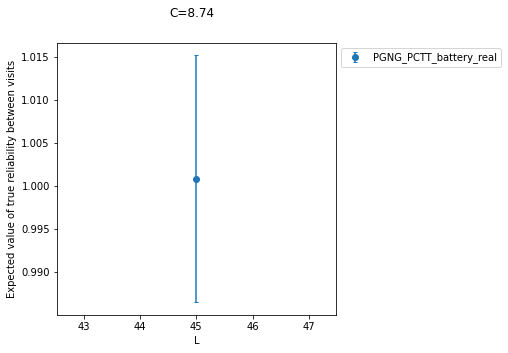

In [8]:
fig, ax = plt.subplots(1,1, figsize=(5,5), sharey=True)

for i,task in enumerate(dic_tasks_results.keys()):
    r_xy_array = dic_tasks_results[task][n_trials]['r_xy_array']

#     ax.scatter(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0))
    ax.errorbar(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0), 
#     ax.errorbar(task, r_xy_array.mean(axis=0), 
                yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2, label=task)

    ax.set_ylabel('Expected value of true reliability between visits')
    ax.set_xlabel('L')

plt.suptitle(f"C={dic_tasks_results[task]['defined_C']:.2f}")
plt.legend(bbox_to_anchor=(1,1))
plt.show()
# axs[1].scatter(n_trials_list_PGNG_orig, r_xy_array.mean(axis=0))
# axs[1].errorbar(n_trials_list_PGNG_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
# axs[1].set_ylabel('Expected value of true reliability between visits')
# axs[1].set_xlabel('L')


In [9]:
# fig, axs = plt.subplots(1,2, figsize=(9,5), sharey=True)

# for task,ax in zip(dic_tasks_results.keys(), axs.flatten()):
#     r_xy_array = dic_tasks_results[task][n_trials]['r_xy_array']

#     ax.scatter(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0))
#     ax.errorbar(dic_tasks_results[task][n_trials]['n_trials_list_orig'], r_xy_array.mean(axis=0), 
#                 yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)

#     ax.set_ylabel('Expected value of true reliability between visits')
#     ax.set_xlabel('L')

#     ax.set_title(f"{task}, C={dic_tasks_results[task]['defined_C']:.2f}")
# plt.show()
# # axs[1].scatter(n_trials_list_PGNG_orig, r_xy_array.mean(axis=0))
# # axs[1].errorbar(n_trials_list_PGNG_orig, r_xy_array.mean(axis=0), yerr=np.nanstd(r_xy_array, axis=0), fmt='o', capsize=2)
    
# # axs[1].set_ylabel('Expected value of true reliability between visits')
# # axs[1].set_xlabel('L')


#### Combine the dictionaries
[top](#top)

In [10]:
# make a copy
dic_tasks_results_backup = dic_tasks_results

# load the saved dict with reliability errors
with open(os.path.join(path_results, 'simulated_reliability_range_largestL_nsim_1000.pkl'), 'rb') as f:
    dic_reliability_error = pickle.load(f)
    

print(dic_reliability_error.keys())
dic_reliability_error

dict_keys(['FMP_longitudinal_1d_synthetic', 'FMP_longitudinal_1d_real', 'FMP_longitudinal_2d_synthetic', 'FMP_longitudinal_2d_real', 'FMP_longitudinal_3d_synthetic', 'FMP_longitudinal_3d_real', 'FMP_battery_real', 'MST_battery_real', 'emotion_matching_battery_real', 'emotion_labelling_battery_real', 'SCAP_battery_real', 'CCMT_battery_real', 'GFMT_battery_real', 'car_matching_battery_real', 'PIM_MC_battery_real', 'PGNG_battery_real', 'PIM_recog_battery_real', 'SCAP_Cowan_battery_real', 'MST_LDI_battery_real', 'MST_REC_battery_real', 'PGNG_PCIT_battery_real'])


{'FMP_longitudinal_1d_synthetic': {'original_C': 24.23783939774275,
  'defined_C': 24.118919698871373,
  256: {'data': array([[0, 1, 1, ..., 0, 0, 1],
          [0, 1, 0, ..., 0, 0, 0],
          [0, 0, 1, ..., 0, 1, 0],
          ...,
          [1, 1, 1, ..., 1, 0, 1],
          [0, 0, 1, ..., 1, 0, 0],
          [1, 0, 0, ..., 1, 0, 1]], dtype=uint8),
   'array_corr_fxn_orig': array([[[0.71799111, 0.72446091, 0.75183189, ..., 0.72330662,
            0.73193903, 0.73302571]],
   
          [[0.78102795, 0.71581481, 0.73616726, ..., 0.73774696,
            0.74129592, 0.7455944 ]],
   
          [[0.75107317, 0.7192747 , 0.7177304 , ..., 0.74740491,
            0.73033875, 0.70729495]],
   
          ...,
   
          [[0.77140676, 0.74320533, 0.78862551, ..., 0.74740208,
            0.76149436, 0.72674804]],
   
          [[0.75420734, 0.7620906 , 0.76165159, ..., 0.75278927,
            0.73020611, 0.70350926]],
   
          [[0.72929245, 0.73393746, 0.723851  , ..., 0.7103814 ,
  

In [11]:
# save this dic to it
for key in dic_tasks_results.keys():
    dic_reliability_error[key] = dic_tasks_results[key]

In [12]:
# save
with open(os.path.join(path_results, f'simulated_reliability_range_largestL_nsim_{n_splits}.pkl'), 'wb') as f:
    pickle.dump(dic_reliability_error, f)
        


In [13]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu -iv

Author: Jan Kadlec

Last updated: Thu Dec 28 2023

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 23.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

numpy     : 1.19.1
matplotlib: 3.6.2
seaborn   : 0.11.1
sys       : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]
pandas    : 1.2.4



[top](#top)